# 2.7 병렬 처리를 통한 효율 개선 (feat. 프롬프트 엔지니어링)

- 아주 specific한 에이전트를 개발하는 경우 유리합니다 
- 답변을 생성할 때 다양한 정보가 필요하다면 병렬 처리를 통해 시간을 절약할 수 있습니다

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str # 사용자 질문
    answer: str # 세율
    tax_base_equation: str # 과세표준 계산 수식 
    tax_deduction: str # 공제액 
    market_ratio: str # 공정시장가액비율
    tax_base: str # 과세표준 계산
    
graph_builder = StateGraph(AgentState)

In [3]:
from langchain_chroma import Chroma
from langchain_openai import AzureOpenAIEmbeddings

# embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')
embedding_function = AzureOpenAIEmbeddings(
    model='text-embedding-3-large',
    azure_endpoint='https://jason-m5amy0cl-westus3.cognitiveservices.azure.com/',
    api_key='2ATphuKxYcY7lXd6Vb1Tzlf2gdx4P5SdoVQ3Tz8QZiSTyisvAcJ9JQQJ99ALACMsfrFXJ3w3AAAAACOGdMk4'
)
vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'real_estate_tax',
    persist_directory='./real_estate_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [4]:
query = '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?'

In [5]:
from langchain_openai import AzureChatOpenAI
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

rag_prompt = hub.pull('rlm/rag-prompt')

llm = AzureChatOpenAI(
    azure_deployment='gpt-4o-2024-11-20',
    api_version='2024-08-01-preview',   
)

/Users/jasonkang/.pyenv/versions/3.12.2/envs/inflearn-langgraph-lecture/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [6]:

tax_base_retrieval_chain = (
    {'context': retriever, 'question': RunnablePassthrough()} 
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

tax_base_equation_prompt = ChatPromptTemplate.from_messages([
    ('system', '사용자의 질문에서 과세표준을 계산하는 방법을 수식으로 나타내주세요. 부연설명 없이 수식만 리턴해주세요'),
    ('human', '{tax_base_equation_information}')
])

tax_base_equation_chain = (
    {'tax_base_equation_information': RunnablePassthrough()}
    | tax_base_equation_prompt
    | llm
    | StrOutputParser()
)

tax_base_chain = {'tax_base_equation_information' : tax_base_retrieval_chain} | tax_base_equation_chain

def get_tax_base_equation(state: AgentState):
    tax_base_equation_question = '주택에 대한 종합부동산세 계산시 과세표준을 계산하는 방법을 수식으로 표현해서 알려주세요'
    tax_base_equation = tax_base_chain.invoke(tax_base_equation_question)
    return {'tax_base_equation': tax_base_equation}

In [7]:

tax_deduction_chain = (
    {'context': retriever, 'question': RunnablePassthrough()} 
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

def get_tax_deduction(state: AgentState):
    tax_deduction_question = '주택에 대한 종합부동산세 계산시 공제금액을 알려주세요'
    tax_deduction = tax_deduction_chain.invoke(tax_deduction_question)
    return {'tax_deduction': tax_deduction}

In [8]:
from langchain_community.tools import TavilySearchResults
from datetime import date

tavily_search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

tax_market_ratio_prompt = ChatPromptTemplate.from_messages([
    ('system', f'아래 정보를 기반으로 공정시장 가액비율을 계산해주세요\n\nContext:\n{{context}}'),
    ('human', '{query}')
])

def get_market_ratio(state: AgentState):
    query = f'오늘 날짜:({date.today()})에 해당하는 주택 공시가격 공정시장가액비율은 몇%인가요?'
    context = tavily_search_tool.invoke(query)
    tax_market_ratio_chain = (
        tax_market_ratio_prompt
        | llm
        | StrOutputParser()
    )
    market_ratio = tax_market_ratio_chain.invoke({'context': context, 'query': query})
    return {'market_ratio': market_ratio}

In [9]:
from langchain_core.prompts import PromptTemplate

tax_base_calculation_prompt = ChatPromptTemplate.from_messages(
    [
        ('system',"""
주어진 내용을 기반으로 과세표준을 계산해주세요

과세표준 계산 공식: {tax_base_equation}
공제금액: {tax_deduction}
공정시장가액비율: {market_ratio}"""),
        ('human', '사용자 주택 공시가격 정보: {query}')
    ]
)

def calculate_tax_base(state:AgentState):
    tax_base_equation = state['tax_base_equation']
    tax_deduction = state['tax_deduction']
    market_ratio = state['market_ratio']
    query = state['query']
    tax_base_calculation_chain = (
        tax_base_calculation_prompt
        | llm
        | StrOutputParser()
    )
    tax_base = tax_base_calculation_chain.invoke({
        'tax_base_equation': tax_base_equation,
        'tax_deduction': tax_deduction,
        'market_ratio': market_ratio,
        'query': query
    })
    print(f'tax_base == {tax_base}')
    return {'tax_base': tax_base}

In [11]:
tax_rate_calculation_prompt = ChatPromptTemplate.from_messages([
    ('system', '''당신은 종합부동산세 계산 전문가입니다. 아래 문서를 참고해서 사용자의 질문에 대한 종합부동산세를 계산해주세요

종합부동산세 세율:{context}'''),
    ('human', '''과세표준과 사용자가 소지한 주택의 수가 아래와 같을 때 종합부동산세를 계산해주세요

과세표준: {tax_base}
주택 수:{query}''')
])

def calculate_tax_rate(state: AgentState):
    query = state['query']
    tax_base = state['tax_base']
    context = retriever.invoke(query)
    tax_rate_chain = (
        tax_rate_calculation_prompt
        | llm
        | StrOutputParser()
    )
    tax_rate = tax_rate_chain.invoke({
        'context': context, 
        'tax_base': tax_base, 
        'query': query
    })
    print(f'tax_rate == {tax_rate}')
    return {'answer': tax_rate}

- `node`를 추가하고 `edge`로 연결합니다
- 여기서 하나의 `node`에서 여러 `node`들을 연결하면 병렬로 작업이 가능합니다

In [15]:
graph_builder.add_node('get_tax_base_equation', get_tax_base_equation)
graph_builder.add_node('get_tax_deduction', get_tax_deduction)
graph_builder.add_node('get_market_ratio', get_market_ratio)
graph_builder.add_node('calculate_tax_base', calculate_tax_base)
graph_builder.add_node('calculate_tax_rate', calculate_tax_rate)

In [16]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'get_tax_base_equation')
graph_builder.add_edge(START, 'get_tax_deduction')
graph_builder.add_edge(START, 'get_market_ratio')
graph_builder.add_edge('get_tax_base_equation', 'calculate_tax_base')
graph_builder.add_edge('get_tax_deduction', 'calculate_tax_base')
graph_builder.add_edge('get_market_ratio', 'calculate_tax_base')
graph_builder.add_edge('calculate_tax_base', 'calculate_tax_rate')
graph_builder.add_edge('calculate_tax_rate', END)

In [17]:
graph = graph_builder.compile()

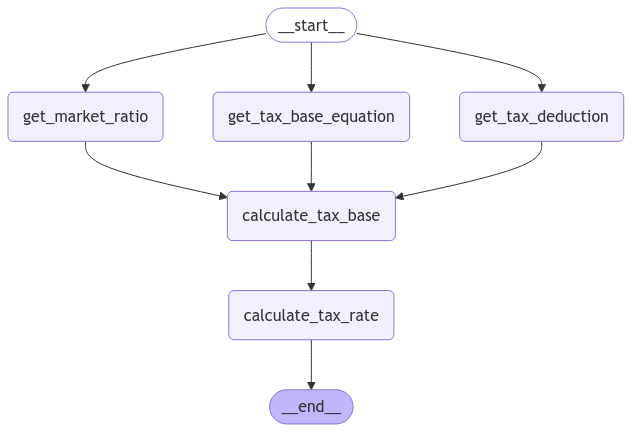

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
initial_state = {'query': query}
graph.invoke(initial_state)

context == [{'url': 'https://m.blog.naver.com/bigtiger001/223416545346', 'content': '2024년 재산세 과표, 세율 종합정리 (공정시장가액비율, 토지, 1주택자 특례, 납세기준일 7월과 9월) : 네이버 블로그 2024년 재산세 과표, 세율 종합정리 (공정시장가액비율, 토지, 1주택자 특례, 납세기준일 7월과 9월) 이에 2024년 재산세 과표, 세율 등을 정리해 보는 포스팅입니다. 1. 재산세 개요\u200b 2. 재산세 산출식 3. 재산세 시가표준액(공시가격) 4. 재산세 공정시장가액비율 즉 재산세 과표가 3억이하시 43%, 6억이하시 44%, 6억초과시 45%가 적용되었습니다. 5. 재산세 세율 재산세 세율은 과세표준에 따라 0.1~0.4%가 적용됩니다. 재산세 과표가 5.4억 초과되는 1주택자의 경우, 특례에 해당되지 않아 0.4%가 적용됩니다. \u200b재산세 도시지역분은 이전의 도시계획세로 도시계획에 필요한 비용을 충당하기 위하여 지정된 토지, 건축물에 부과하는 세금으로 재산세 과세표준의 0.14%가 부가됩니다. ◆ 재산세 가산금 ◆2024년부터 재산세 과세표준 상한제 도입 \u200b 7. 2023년 재산세 Case (송파아파트 사례) #재산세 {"title":"2024년 재산세 과표, 세율 종합정리 (공정시장가액비율, 토지, 1주택자 특례, 납세기준일 7월과 9월)","source":"https://blog.naver.com/bigtiger001/223416545346","blogName":"60story","blogId":"bigtiger001","domainIdOrBlogId":"bigtiger001","nicknameOrBlogId":"60story sbt","logNo":223416545346,"smartEditorVersion":4,"lineDisplay":true,"outsideDisplay":true,"cafeDisplay":true,"blogDisplay":true

{'query': '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?',
 'answer': '주어진 정보를 바탕으로 사용자의 **종합부동산세**를 계산하겠습니다. 다음 단계를 따릅니다.\n\n---\n\n### 1. 과세표준 계산\n#### 주택 공시가격 총합:\n- \\( 5억 + 10억 + 20억 = 35억 원 \\)\n\n#### 공제금액:\n- 사용자는 **3주택**을 보유하고 있으므로, 일반 납세자로 간주되어 공제금액은 **9억 원**입니다.\n\n#### 공정시장가액비율:\n- 공정시장가액비율은 **60%**로 적용됩니다.\n\n#### 과세표준:\n\\[\n\\text{과세표준} = (주택 공시가격 총합 - 공제금액) \\times \\text{공정시장가액비율}\n\\]\n\\[\n\\text{과세표준} = (35억 - 9억) \\times 60\\%\n\\]\n\\[\n\\text{과세표준} = 26억 \\times 0.6 = 15.6억 원\n\\]\n\n---\n\n### 2. 세율 적용\n사용자는 **3주택 이상**을 소유하고 있으므로, **3주택 이상**의 세율 표를 사용합니다.\n\n#### 과세표준: 15.6억 원\n15.6억 원은 **12억 초과 25억 이하** 구간에 해당합니다.  \n따라서, 세율은 **960만 원 + (12억 원을 초과하는 금액의 1천분의 20)** 입니다.\n\n#### 계산:\n1. \\( 12억 원 초과 금액 \\):\n\\[\n15.6억 - 12억 = 3.6억 원\n\\]\n\n2. 초과 금액에 대한 세율 적용:\n\\[\n3.6억 \\times (1천분의 20) = 3.6억 \\times 0.002 = 720만 원\n\\]\n\n3. 기본 세액에 추가:\n\\[\n960만 원 + 720만 원 = 1,680만 원\n\\]\n\n---\n\n### 최종 결과\n사용자가 납부해야 할 **종합부동산세**는 **1,680만 원**입니다.\n\n---\n\n추가로